Working with real-world data: change detection with Sentinel-2 imagery
===


In this notebook, we compare [Sentinel-2](https://en.wikipedia.org/wiki/Sentinel-2) imagery from 2 different timestamps at the same location and detect changes between them using a pre-trained change detection model. This is the same model as discussed in [this blog post](https://element84.com/machine-learning/change-detection-with-raster-vision/).

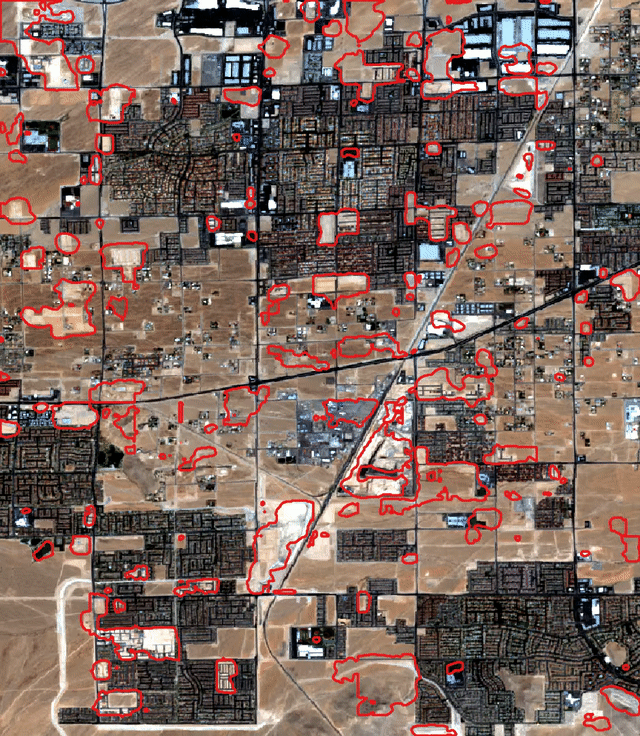

<hr style="border: 2px solid gray">

# Using a STAC API

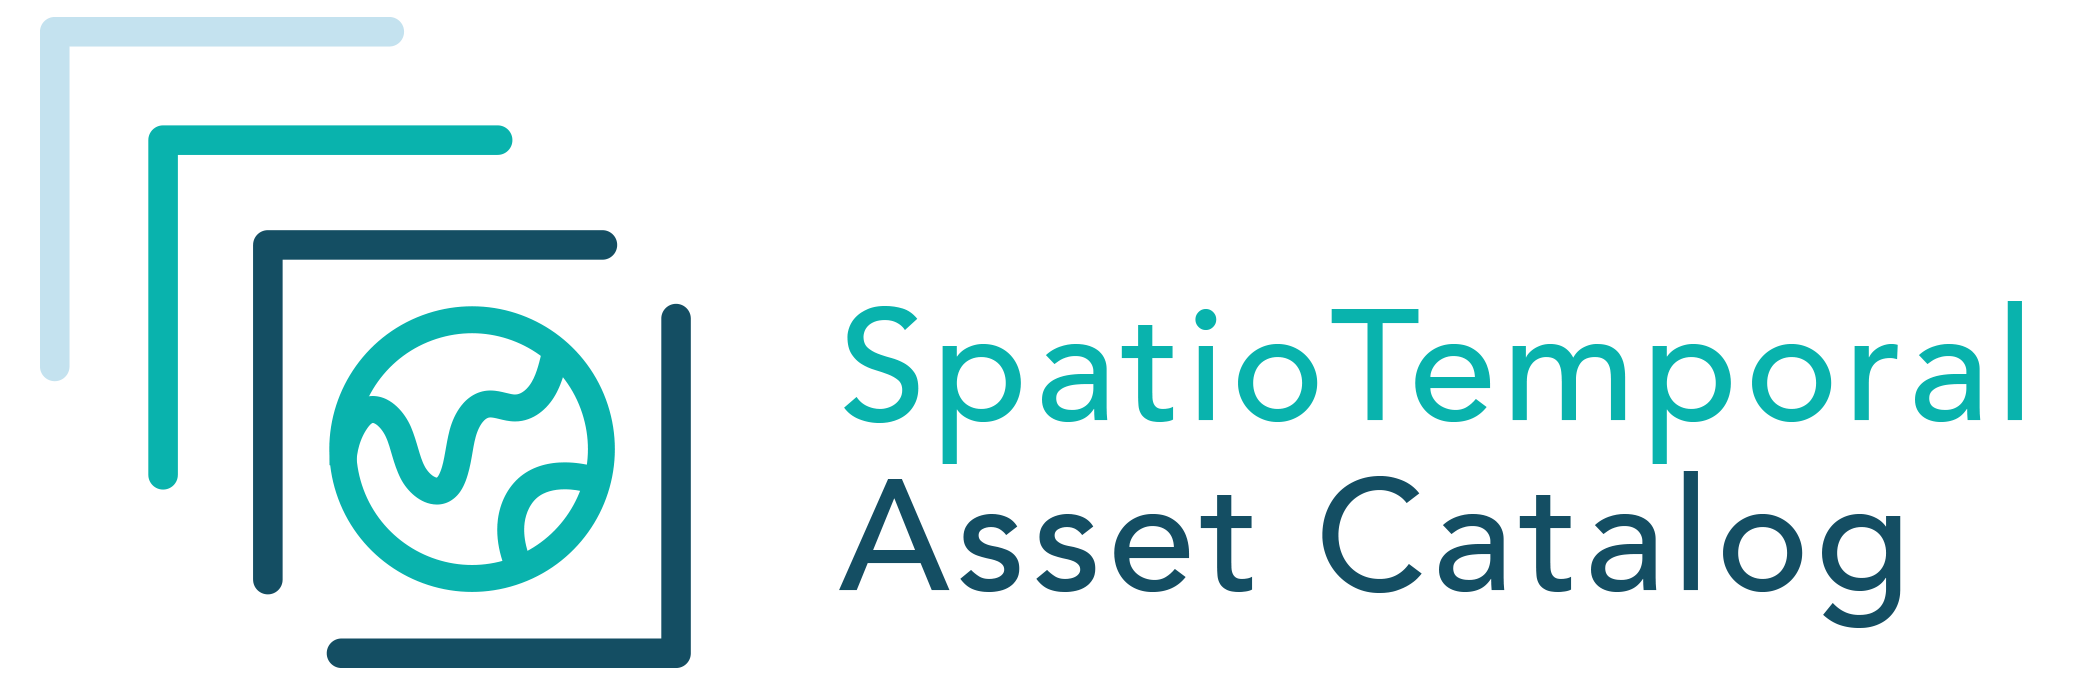

In [ ]:
from os.path import join

In [ ]:
model_bundle_uri = 'https://azavea-research-public-data.s3.amazonaws.com/raster-vision/examples/s2-change-detection/model-bundle.zip'

In [ ]:
out_dir = 'data/s2_change_detection/'

In [ ]:
from rastervision.core.box import Box

bbox = Box(ymin=36.046048, xmin=-114.972675, ymax=35.985617, xmax=-114.911484)
bbox

In [ ]:
bbox_polygon = bbox.to_shapely().oriented_envelope
bbox_polygon

In [ ]:
from shapely.geometry import mapping

search_geometry = mapping(bbox_polygon)
search_geometry

In [ ]:
import pystac_client

catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')
catalog

In [ ]:
items_old = catalog.search(
    intersects=search_geometry,
    datetime='2017-04-01/2017-05-01',
    collections=['sentinel-2-l2a'],
    query={
        'eo:cloud_cover': {
            'lt': 5
        }
    },
).item_collection()

Tip: If after running the cell below you notice the notebook lagging, right-click the cell and click `"Clear Cell Output"`.

In [ ]:
items_old

In [ ]:
items_new = catalog.search(
    intersects=search_geometry,
    datetime='2024-04-01/2024-05-01',
    collections=['sentinel-2-l2a'],
    query={
        'eo:cloud_cover': {
            'lt': 5
        }
    },
).item_collection()

Tip: If after running the cell below you notice the notebook lagging, right-click the cell and click `"Clear Cell Output"`.

In [ ]:
items_new

In [ ]:
item_old = items_old[0]
item_new = items_new[0]

In [ ]:
import contextily as cx
from matplotlib import pyplot as plt
from matplotlib import patches

plt.close('all')
fig, ax = plt.subplots(figsize=(6, 6))

# plot bbox
xy_coords = bbox.to_points()
bbox_geometry = patches.Polygon(xy_coords, color='red', fill=False)
ax.add_patch(bbox_geometry)

# plot item_old geometry
xy_coords = item_old.geometry['coordinates'][0]
item_old_geometry = patches.Polygon(xy_coords, color='k', ls='--', fill=False)
ax.add_patch(item_old_geometry)

# plot item_new geometry
xy_coords = item_new.geometry['coordinates'][0]
item_new_geometry = patches.Polygon(xy_coords, color='steelblue', fill=False)
ax.add_patch(item_new_geometry)

ax.autoscale()
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)

plt.show()

---

# Predicting with the Raster Vision `predict_scene` CLI command

In [ ]:
!rastervision predict_scene --help

## Define configs

In [ ]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(names=['no change', 'change'])

In [ ]:
BANDS = [
    'coastal',  # B01
    'blue',  # B02
    'green',  # B03
    'red',  # B04
    'rededge1',  # B05
    'rededge2',  # B06
    'rededge3',  # B07
    'nir',  # B08
    'nir09',  # B09
    'swir16',  # B11
    'swir22',  # B12
    'nir08',  # B8A
]

In [ ]:
from rastervision.pipeline.file_system.utils import json_to_file

item_uri_old = join(out_dir, 'stac-item-t1.json')
json_to_file(item_old.to_dict(), item_uri_old)

item_uri_new = join(out_dir, 'stac-item-t2.json')
json_to_file(item_new.to_dict(), item_uri_new)

### Compute band stats for normalization

In [ ]:
from rastervision.core.data import (STACItemConfig, StatsTransformerConfig,
                                    XarraySourceConfig)

raster_source_old_config = XarraySourceConfig(
    stac=STACItemConfig(uri=item_uri_old, assets=BANDS),
    stackstac_args=dict(rescale=False, fill_value=0, dtype='uint16'),
    bbox_map_coords=tuple(bbox),
    allow_streaming=True,
)
raster_source_new_config = XarraySourceConfig(
    stac=STACItemConfig(uri=item_uri_new, assets=BANDS),
    stackstac_args=dict(rescale=False, fill_value=0, dtype='uint16'),
    bbox_map_coords=tuple(bbox),
    allow_streaming=True,
)

In [ ]:
from rastervision.core.data import StatsTransformer

stats_tf = StatsTransformer.from_raster_sources([
    raster_source_old_config.build(), 
    raster_source_new_config.build(),
])

In [ ]:
stats_tf.stats

In [ ]:
stats_uri = join(out_dir, 'stats.json')
stats_tf.stats.save(stats_uri)

### Define `RasterSourceConfig`

In [ ]:
raster_source_old_config = XarraySourceConfig(
    stac=STACItemConfig(uri=item_uri_old, assets=BANDS),
    # we're missing B10, so we duplicate B09 as a workaround
    channel_order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11],
    stackstac_args=dict(rescale=False, fill_value=0, dtype='uint16'),
    transformers=[StatsTransformerConfig(stats_uri=stats_uri)],
    bbox_map_coords=tuple(bbox),
    allow_streaming=False,
)
raster_source_new_config = XarraySourceConfig(
    stac=STACItemConfig(uri=item_uri_new, assets=BANDS),
    # we're missing B10, so we duplicate B09 as a workaround
    channel_order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11],
    stackstac_args=dict(rescale=False, fill_value=0, dtype='uint16'),
    transformers=[StatsTransformerConfig(stats_uri=stats_uri)],
    bbox_map_coords=tuple(bbox),
    allow_streaming=False,
)

In [ ]:
from rastervision.core.data import MultiRasterSourceConfig

raster_source_config = MultiRasterSourceConfig(
    raster_sources=[raster_source_old_config, raster_source_new_config])

### Define `LabelStoreConfig`

In [ ]:
from rastervision.core.data import (SemanticSegmentationLabelStoreConfig,
                                    PolygonVectorOutputConfig)

label_store_config = SemanticSegmentationLabelStoreConfig(
    uri=out_dir,
    smooth_output=True,
    vector_output=[
        PolygonVectorOutputConfig(
            # class ID of the "change" class
            class_id=class_config.get_class_id('change'),
            # threshold to use for creating binary mask that will then be vectorized
            threshold=0.25,
            # filter out positive regions in the binary mask smaller than
            # this diameter (in pixels)
            denoise=8,
        ),
    ],
)

In [ ]:
from rastervision.core.data.utils import geoms_to_geojson
from shapely.geometry import shape

aoi_geom = shape(item_old.geometry).intersection(shape(item_new.geometry))
aoi_geojson = geoms_to_geojson([aoi_geom])
aoi_uri = join(out_dir, 'aoi.json')
json_to_file(aoi_geojson, aoi_uri)

In [ ]:
from rastervision.core.data import SceneConfig

scene_config = SceneConfig(
    id='',
    raster_source=raster_source_config,
    label_store=label_store_config,
    aoi_uris=[aoi_uri],
)

In [ ]:
from rastervision.core.rv_pipeline import SemanticSegmentationPredictOptions

pred_opts = SemanticSegmentationPredictOptions(chip_sz=100,
                                               stride=50,
                                               crop_sz='auto')

In [ ]:
scene_config_uri = join(out_dir, 'scene-config.json')
scene_config.to_file(scene_config_uri)

pred_opts_uri = join(out_dir, 'pred-opts.json')
pred_opts.to_file(pred_opts_uri)

In [ ]:
print(f'{scene_config_uri=}')
print(f'{pred_opts_uri=}')

## Run the CLI command

In [ ]:
!rastervision predict_scene {model_bundle_uri} {scene_config_uri} --predict_options_uri {pred_opts_uri}

---

# Inpect results in QGIS

- Find the href of the `visual` asset for each item and download it (~300 MB each)
- Load both in QGIS, so we can switch back and forth between them
- Load the model's predictions
- Do the predictions make sense? How good are they?

In [ ]:
item_old.assets['visual'].href

In [ ]:
item_new.assets['visual'].href

In [ ]:
from rastervision.core.data.utils import geoms_to_geojson
from rastervision.pipeline.file_system.utils import json_to_file

bbox_geojson = geoms_to_geojson([bbox_polygon])
json_to_file(bbox_geojson, join(out_dir, 'bbox.json'))

---

# AWS SageMaker

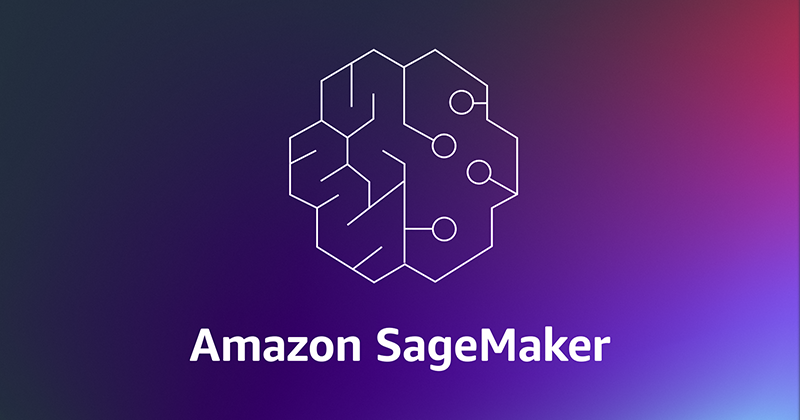

>_SageMaker, SageMaker, you're the one I choose,_  
_From data prep to model deploy, I never lose._  
_Jupyter Notebooks, Python code, we're ready to cruise,_  
_With SageMaker, SageMaker, I never get the blues._  

― ChatGPT on SageMaker

## Put config files on S3

In [ ]:
your_name = 'test'

In [ ]:
out_dir = f's3://ml-workshop/2024_05_15/{your_name}/s2_change_detection/'
out_dir

In [ ]:
stats_uri = join(out_dir, 'stats.json')
stats_tf.stats.save(stats_uri)

In [ ]:
item_uri_old = join(out_dir, 'stac-item-t1.json')
json_to_file(item_old.to_dict(), item_uri_old)

item_uri_new = join(out_dir, 'stac-item-t2.json')
json_to_file(item_new.to_dict(), item_uri_new)

In [ ]:
raster_source_old_config = XarraySourceConfig(
    stac=STACItemConfig(uri=item_uri_old, assets=BANDS),
    channel_order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11],
    stackstac_args=dict(rescale=False, fill_value=0, dtype='uint16'),
    transformers=[StatsTransformerConfig(stats_uri=stats_uri)],
    bbox_map_coords=tuple(bbox),
    allow_streaming=False,
)
raster_source_new_config = XarraySourceConfig(
    stac=STACItemConfig(uri=item_uri_new, assets=BANDS),
    channel_order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11],
    stackstac_args=dict(rescale=False, fill_value=0, dtype='uint16'),
    transformers=[StatsTransformerConfig(stats_uri=stats_uri)],
    bbox_map_coords=tuple(bbox),
    allow_streaming=False,
)
raster_source_config = MultiRasterSourceConfig(
    raster_sources=[raster_source_old_config, raster_source_new_config])

In [ ]:
label_store_config = SemanticSegmentationLabelStoreConfig(
    uri=out_dir,
    smooth_output=True,
    vector_output=[
        PolygonVectorOutputConfig(
            # class ID of the "change" class
            class_id=class_config.get_class_id('change'),
            # threshold to use for creating binary mask that will then be vectorized
            threshold=0.25,
            # filter out positive regions in the binary mask smaller than
            # this diameter (in pixels)
            denoise=8,
        ),
    ],
)

In [ ]:
aoi_geom = shape(item_old.geometry).intersection(shape(item_new.geometry))
aoi_geojson = geoms_to_geojson([aoi_geom])
aoi_uri = join(out_dir, 'aoi.json')
json_to_file(aoi_geojson, aoi_uri)

scene_config = SceneConfig(
    id='',
    raster_source=raster_source_config,
    label_store=label_store_config,
    aoi_uris=[aoi_uri],
)
pred_opts = SemanticSegmentationPredictOptions(chip_sz=100,
                                               stride=50,
                                               crop_sz='auto')
scene_config_uri = join(out_dir, 'scene-config.json')
scene_config.to_file(scene_config_uri)

pred_opts_uri = join(out_dir, 'pred-opts.json')
pred_opts.to_file(pred_opts_uri)

## Submit SageMaker job

In [ ]:
from rastervision.aws_sagemaker import AWSSageMakerRunner

runner = AWSSageMakerRunner()

The cell below will submit a job to SageMaker and print out the output logged by the job. 

The cell will stay busy until the job is complete. Interrupting the cell's execution will cause the job to fail.

In [ ]:
runner.run_command(
    cmd=[
        'rastervision', 'predict_scene', model_bundle_uri, scene_config_uri,
        '--predict_options_uri', pred_opts_uri
    ],
    # AWS IAM role with the necessary permissions
    role='SageMaker-GeoMLWorkshopParticipant',
    # URI to Raster Vision docker image on AWS ECR
    image_uri=
    '992382462803.dkr.ecr.us-east-1.amazonaws.com/raster-vision-pytorch',
    # instance with one GPU
    instance_type='ml.p3.2xlarge',
    # job name
    job_name=f'ml-workshop-s2-change-detection-{your_name}',
)

In [ ]:
!aws s3 ls {out_dir}

---

## Setting up SageMaker

### Create ECR repository

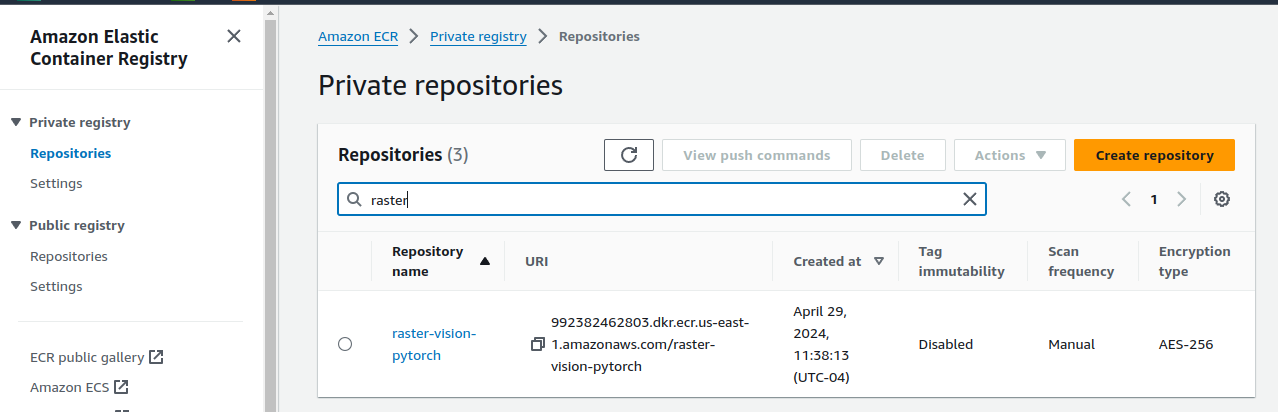

### Upload docker image to ECR

Let's say you've run `aws configure` and set up a profile called `workshop` and have [built a Raster Vision docker image](https://docs.rastervision.io/en/stable/setup/index.html#docker-scripts), tagged as `raster-vision-pytorch:latest`.

You can then push it to ECR like so (replacing `992382462803` and `us-east-1` with your account ID and region respectively):

```sh
aws ecr get-login-password --region us-east-1 --profile workshop | docker login --username AWS --password-stdin 992382462803.dkr.ecr.us-east-1.amazonaws.com
```

```sh
docker push 992382462803.dkr.ecr.us-east-1.amazonaws.com/raster-vision-pytorch:latest
```

### Create an IAM role

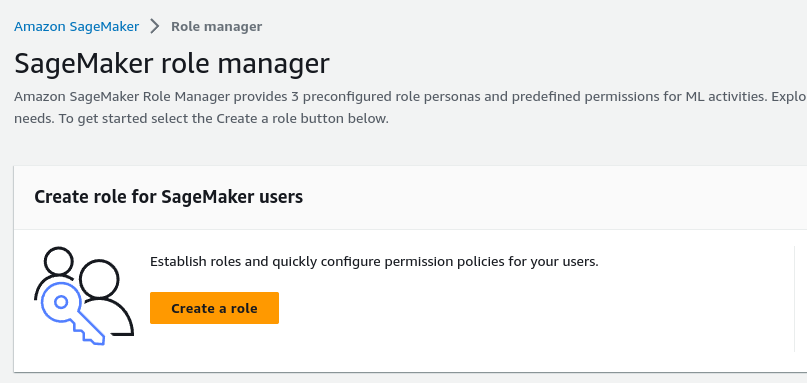

### Request service quote increase

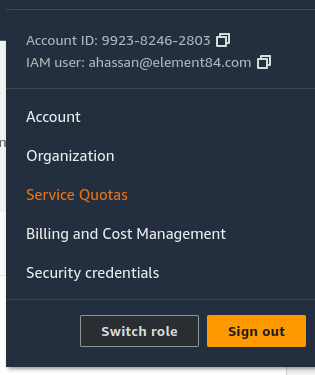

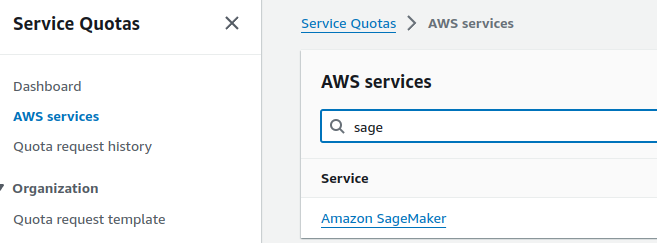

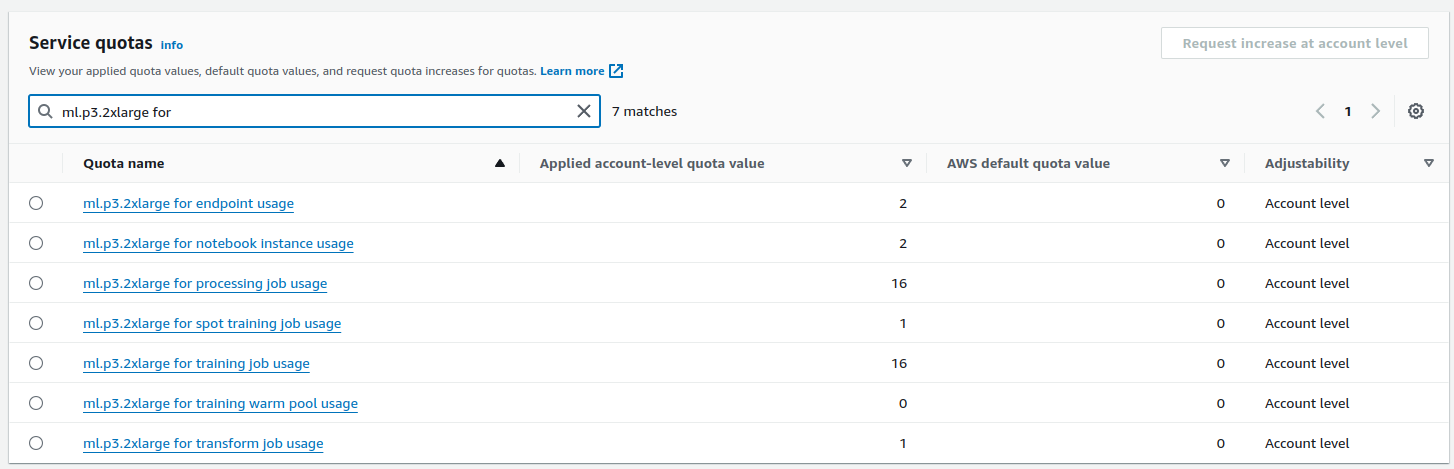